# Filtracja Non-Local Means

## Definicja

Kolejny "poziom wtajemniczenia" w zagadnienie filtracji obrazów to metoda Non-Local Means (NLM).
Została ona zaproponowana w pracy *"A non-local algorithm for image denoising"* (autorzy: Antoni Buades, Bartomeu Coll i Jean Michel Morel) na konferencji CVPR w 2005 roku.

Filtr NLM dany jest zależnością:

\begin{equation}
\hat{I}(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} w(\mathbf{p},\mathbf{x})I(\mathbf{p})
\tag{1}
\end{equation}

gdzie:
- $I$ - obraz wejściowy,
- $\hat{I}$ - obraz wyjściowy (przefiltrowany),
- $\mathbf{x}$ - współrzędne piksela obrazu,
- $V(\mathbf{x})$ - obszar poszukiwań piksela, dla którego przeprowadzana jest filtracja,
- $w$ - waga punktu $\mathbf{p}$ z obszaru poszukiwań.

Wróćmy na chwilę do filtracji bilateralnej. Tam waga danego piksela z kontekstu zależała od dwóch czynników - odległości przestrzennej pomiędzy pikselami oraz różnicy w jasności/kolorze pomiędzy pikselami (tzw. przeciwdziedzina).
Filtr NLM stanowi uogólnienie tej metody - do obliczania wag nie wykorzystuje się już pojedynczych pikseli ($\mathbf{p}$ i $\mathbf{x}$), a lokalne konteksty ($N(\mathbf{p})$ i $N(\mathbf{x})$).

Waga $w$ dana jest następującą zależnością:

\begin{equation}
w(\mathbf{p},\mathbf{x}) = \frac{1}{Z(\mathbf{x})}\exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\tag{2}
\end{equation}

gdzie:
\begin{equation}
Z(\mathbf{x}) = \sum_{\mathbf{p} \in V(\mathbf{x})} \exp(-\frac{|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||^2_{2}}{\alpha \sigma^2})
\tag{3}
\end{equation}

- $|| \cdot ||$ - jest normą $L_2$ odległości pomiędzy dwoma kontekstami,
- $v$ oznacza mnożenie punktowe kontekstu $N$ przez dwuwymiarową maskę Gaussa o odpowiadających kontekstowi wymiarach,
- $\alpha$ > 0 - parametr sterujący filtracją,
- $\sigma$ - parametr szumu stacjonarnego występującego na obrazie (w przypadku szumu niestacjonarnego, parametr $\sigma$ musi zostać dopasowany lokalnie tj. $\sigma = \sigma(\mathbf{x})$).

## Analiza działania

Zastanówmy sie teraz jak działa filtra NLM. Najprościej to zrozumieć na rysunku.

![Ilustracja NLM](https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/nlm.png)

1. Dla rozważanego piksela $\mathbf{x}$ definiujemy obszar poszukiwań $V(\mathbf{x})$. Uwaga - obszar poszukiwań ($V$) jest jednostką większą niż otocznie/kontekst ($N$).

2. Następnie, dla każdego z pikseli $\mathbf{p} \in  V(\mathbf{x})$ oraz samego $\mathbf{x}$ definiujemy otocznie/kontekst odpowiednio $N(\mathbf{p})$ i $N(\mathbf{x})$.

3. Wracamy do równania definiującego wagę  $w(\mathbf{p},\mathbf{x})$, a konkretnie do wyrażenia $|| v(N(\mathbf{p})) - v(N(\mathbf{x})) ||$. Przeanalizujmy co ono oznacza. Mamy dwa otoczenia: $N(\mathbf{p})$ i $N(\mathbf{x})$. Każde z nich mnożymy przez odpowiadającą maskę Gaussa - funkcja $v$. Otrzymujemy dwie macierze, które odejmujemy od siebie punktowo. Następnie obliczamy kwadrat z normy ($L_2$ definiujemy jako $||X||_2 = \sqrt{\sum_k|X_k|^2}$. Otrzymujemy zatem jedną liczbę, która opisuje nam podobieństwo otoczeń pikseli $\mathbf{x}$ i $\mathbf{p}$. Mała wartość oznacza otoczenia zbliżone, duża - różniące się. Ponieważ, z dokładnością do stałych, liczba ta stanowi wykładnik funkcji $e^{-x}$, to ostatecznie waga jest zbliżona do 1 dla otoczeń podobnych, a szybko maleje wraz z malejącym podobieństwem kontekstów.

4. Podsumowując: jak wynika z powyższej analizy filtr NLM to taki filtr bilateralny, w którym zamiast pojedynczych pikseli porównuje się ich lokalne otoczenia. Wpływa to pozytywnie na jakość filtracji, niestety kosztem złożoności obliczeniowej.

## Implementacja

W ramach zadania należy zaimplementować filtr NLM, ocenić jego działanie w porównaniu do filtra Gaussa i bilateralnego oraz dokonać pomiaru czasu obliczeń (dla trzech wymienionych metod).

Jak już się zrozumie jak działa NLM, jego implementacja jest dość prosta.
Wartość parametru $\alpha$ należy dobrać eksperymentalnie.
Nie należy także "przesadzić" z rozmiarem obszaru poszukiwań (np. 11x11) oraz kontekstu (5x5 lub 3x3).

Wskazówki do implementacji:
- algorytm sprowadza się do dwóch podwójnych pętli for: zewnętrzne po pikselach, wewnętrzne po kolejnych obszarach przeszukań,
- przed realizacją trzeba przemyśleć problem pikseli brzegowych - de facto problemów jest kilka. Po pierwsze nie dla każdego piksela można wyznaczyć pełny obszar przeszukań (tu propozycja, aby filtrację przeprowadzać tylko dla pikseli z pełnym obszarem). Po drugie, ponieważ rozpatrujemy konteksty, to nawet dla piksela o "pełnym" obszarze przeszukań, będą istnieć piksele, dla których nie pełnych kontekstów (sugestia - powiększyć obszar przeszukać, tak aby zawierał konteksty). Ostatni problem jest bardziej techniczny/implementacyjny. Jeśli w kolejnych iteracjach "jawnie" wytniemy fragment o rozmiarach obszaru przeszukiwań, to znowu pojawi się problem brzegowy - tu można albo wyciąć nieco większy obszar, albo cały czas "pracować" na obrazie oryginalnym ("żonglerka indeksami").
- warto sprawdzać indeksy i rozmiary "wycinanych" kontekstów,
- wagi wyliczamy w trzech krokach:
    - obliczenia dla $N(\mathbf{x})$ + inicjalizacja macierzy na wagi,
    - podwójna pętla, w której przeprowadzamy obliczenia dla kolejnych $N(\mathbf{p})$ oraz wyliczamy wagi,
    - normalizacja macierzy wag oraz końcowa filtracja obszaru w wykorzystaniem wag.
- uwaga, obliczenia trochę trwają, nawet dla obrazka 256x256 i względnie niewielkich obszaru przeszukań i kontesktu.

Efekt końcowy:
- porównanie wyników metod: filtr Gaussa, filtr bilateralny oraz filtr NLM (2-3 zdania komentarza),
- porównanie czasu działania powyższych metod (1 zdanie komentarza).


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.io import loadmat
import math
import os

if not os.path.exists("MR_data.mat") :
    !wget https://raw.githubusercontent.com/vision-agh/poc_sw/master/07_Bilateral/MR_data.mat --no-check-certificate

        
mat = loadmat('MR_data.mat')

Input_0 = mat['I_noisy1']
Input_1 = mat['I_noisy2']
Input_2 = mat['I_noisy3']
Input_3 = mat['I_noisy4']
Input_4 = mat['I_noisefree']

In [2]:
def fgaussian(size, sigma):
    # funkcja fgaussian obliczona raz jest aktualna dla wszystkich otoczeń pikseli w obrazku (poza ramkami)
    # przy zdefimiowanej w tej funkcji normie, dodatkowo normalizując współczynniki filtra
    m = n = size
    h, k = m // 2, n // 2
    x, y = np.mgrid[-h:h + 1, -k:k + 1]
    
    l_2 = (x ** 2 + y ** 2)**(1/2)  # norma l_2
    g = np.exp(-(l_2 / (2 * sigma ** 2)))
    
    return g / g.sum()

               
def convolution(img, window_size, delta_s):
    IConv = img.copy()
    X, Y = IConv.shape
    half_size = window_size // 2

    filtr = fgaussian(window_size, delta_s)

    for i in range(0 + half_size, X - half_size):
        for j in range(0 + half_size, Y - half_size):
            p = img[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1]

            # element funkcji obliczającej nową wartość piksela
            # (nie definiowałem osobnej funkcji gdyż są to 2 linijki kodu)
            cos = np.array(filtr * p)
            I_x = cos.sum()
    
            IConv[i][j] = int(I_x)

    return IConv


gamma = lambda y, delta_r: np.exp(-y**2/(2*delta_r**2))

def bilateral(img, window_size, delta_s, delta_r):
    IBilateral = img.copy()
    X, Y = IBilateral.shape
    half_size = window_size // 2

    filtr = fgaussian(window_size, delta_s)

    for i in range(0 + half_size, X - half_size):
        for j in range(0 + half_size, Y - half_size):
            p = img[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1]

            # element funkcji obliczającej nową wartość piksela
            # (nie definiowałem osobnej funkcji gdyż jest to prosty kod)
            I_x = 0
            for m in range(len(p)):
                for n in range(len(p[m])):
                    y = np.abs(p[m][n] - img[i][j]) 
                    I_x += filtr[m][n] * gamma(y, delta_r) * p[m][n]
            
            IBilateral[i][j] = int(I_x)

    return IBilateral

In [3]:
def gauss_mask(size, sigma):
    # funkcja fgaussian obliczona raz jest aktualna dla wszystkich otoczeń pikseli w obrazku (poza ramkami)
    m = n = size
    h, k = m // 2, n // 2
    x, y = np.mgrid[-h:h + 1, -k:k + 1]
    
    g = np.exp(-((x ** 2 + y ** 2) / (2 * sigma ** 2)))
    
    return g / g.sum()

               
def NLM(img, window_size, N_size, sigma, alfa, delta):
    INLM = img.copy()
    X, Y = INLM.shape
    half_size = window_size // 2

    filtr = gauss_mask(N_size, sigma)

    for i in range(0 + half_size, X - half_size):
        for j in range(0 + half_size, Y - half_size):
            V_x = img[i - half_size:i + half_size + 1, j - half_size:j + half_size + 1]  # obszar poszukiwań
            N_x = img[i - N_size//2:i + N_size//2 + 1, j - N_size//2:j + N_size//2 + 1]  # otoczenie x
                
            I_x = 0     # nowa wartość piksela
            factor = 0  # współczynnik normalizujący
            
            for m in range(0 + N_size//2, half_size - N_size//2 + 1):
                for n in range(0 + N_size//2, half_size - N_size//2 + 1):
                    
                    N_p = img[m - N_size//2:m + N_size//2 + 1, n - N_size//2:n + N_size//2 + 1]  # otoczenie p
                    
                    curr_norm = np.sum((filtr*(N_p - N_x))**2)   # pierwiastek w normie znika, gdyż potem normę podnosimy do kwadratu
                    
                    weight = np.exp(-(curr_norm)/(alfa * delta ** 2))
                    factor += weight
                    
                    I_x += weight * V_x[m][n]
            
            INLM[i][j] = int(I_x / factor)

    return INLM


# Komentarz:
Z racji, że przetwarzanie tanych obrazów trwa dosyć długo, zostawiłem w notebooku już wczytane obrazy.

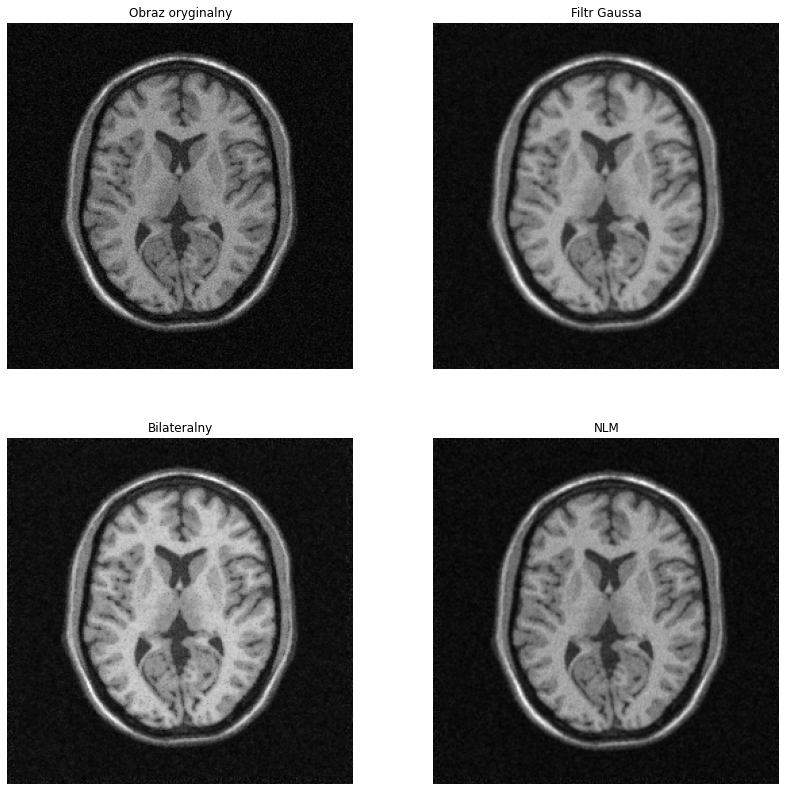

In [4]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches((14, 14))
ax[0, 0].imshow(Input_0, 'gray')
ax[0, 0].set_title('Obraz oryginalny')
ax[0, 0].axis('off')
ax[0,1].imshow(convolution(Input_0, 11, 0.5), 'gray')
ax[0,1].set_title('Filtr Gaussa')
ax[0,1].axis('off')
ax[1,0].imshow(bilateral(Input_0, 11, 0.5, 40), 'gray')
ax[1,0].set_title('Bilateralny')
ax[1,0].axis('off')
ax[1,1].imshow(NLM(Input_0, 11, 5, 0.5, 0.5, 40), 'gray')
ax[1,1].set_title('NLM')
ax[1,1].axis('off')
plt.show()

C:\Users\Tomek\AppData\Local\Temp\ipykernel_5416\3580762237.py:53: RuntimeWarning: overflow encountered in ubyte_scalars
  y = np.abs(p[m][n] - img[i][j])


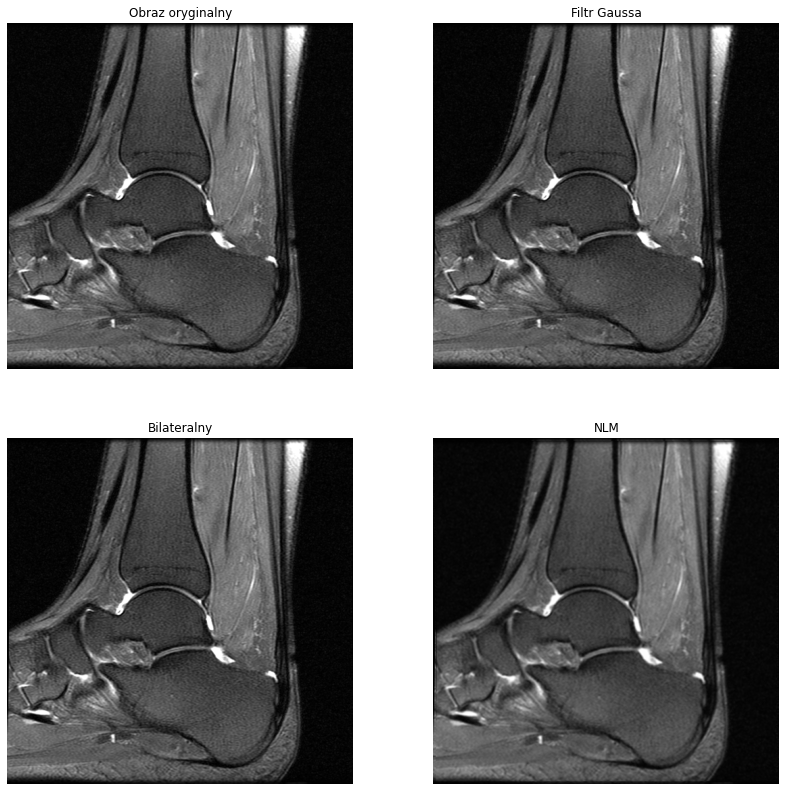

In [5]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches((14, 14))
ax[0, 0].imshow(Input_3, 'gray')
ax[0, 0].set_title('Obraz oryginalny')
ax[0, 0].axis('off')
ax[0,1].imshow(convolution(Input_3, 9, 0.2), 'gray')
ax[0,1].set_title('Filtr Gaussa')
ax[0,1].axis('off')
ax[1,0].imshow(bilateral(Input_3, 9, 0.2, 60), 'gray')
ax[1,0].set_title('Bilateralny')
ax[1,0].axis('off')
ax[1,1].imshow(NLM(Input_3, 9, 3, 0.2, 0.5, 60), 'gray')
ax[1,1].set_title('NLM')
ax[1,1].axis('off')
plt.show()


C:\Users\Tomek\AppData\Local\Temp\ipykernel_5416\3580762237.py:53: RuntimeWarning: overflow encountered in ubyte_scalars
  y = np.abs(p[m][n] - img[i][j])


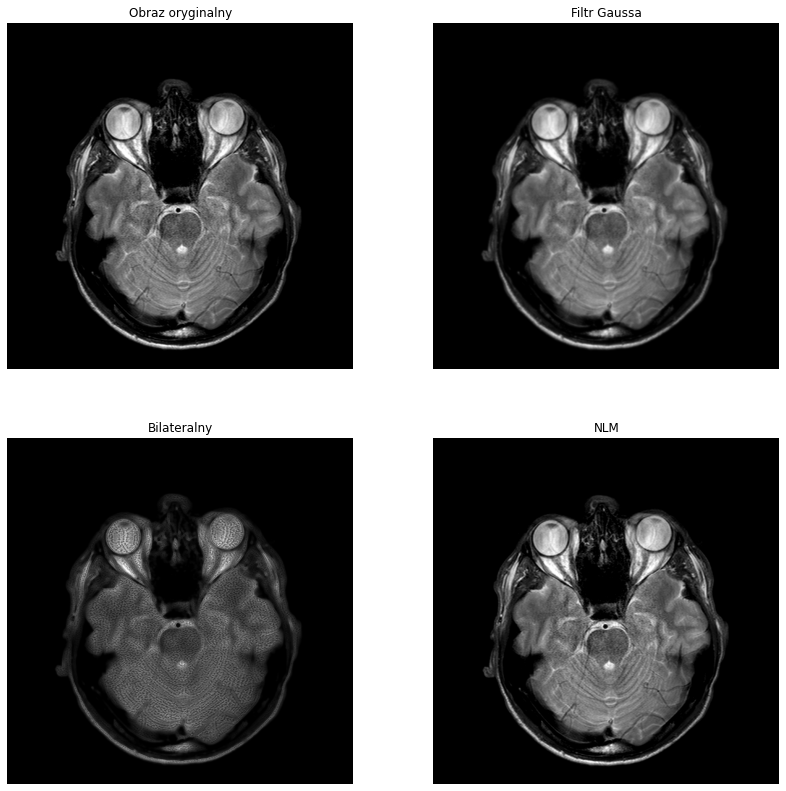

In [6]:
fig, ax = plt.subplots(2, 2)
fig.set_size_inches((14, 14))
ax[0, 0].imshow(Input_2, 'gray')
ax[0, 0].set_title('Obraz oryginalny')
ax[0, 0].axis('off')
ax[0,1].imshow(convolution(Input_2, 9, 0.6), 'gray')
ax[0,1].set_title('Filtr Gaussa')
ax[0,1].axis('off')
ax[1,0].imshow(bilateral(Input_2, 9, 0.6, 50), 'gray')
ax[1,0].set_title('Bilateralny')
ax[1,0].axis('off')
ax[1,1].imshow(NLM(Input_2, 9, 5, 0.6, 0.5, 50), 'gray')
ax[1,1].set_title('NLM')
ax[1,1].axis('off')
plt.show()

#### Z moich obserwacji wynika, że największe znaczenie dla działania filtra ma dobór parametrów (co z tego, że mamy zaimplementowany znakomity filtr skoro, nie umiemy wykorzystać jego stu procent możliwości). Do powyższych testów, starałem się dobrać zbliżone parametry, by jakkolwiek móc porównać działanie różnych filtrów dla tego samego obrazu. Z moich obserwacji wynika, że prawidłowo użyty algorytm NLM daje najlepsze rezultaty, tj. cechuje się najostrzejszymi krawędziami i najlepszym filtrowaniem szumu